## Treinamento Random Forest com minas
Este notebook foi otimizado para usar o pacote minas, tornando o fluxo de pré-processamento, treinamento e avaliação mais robusto e padronizado.

In [ ]:
import os
import pandas as pd
import numpy as np
import minas as mg
import json

# Caminho do arquivo de entrada
input_path = '../data/input_splusgL11.csv'
df_base = pd.read_csv(input_path)
df_base.set_index('TILE_ID', drop=True, inplace=True)

# Conjuntos de filtros
survey_filter = 'SPLUS'
filters = mg.FILTERS[survey_filter]

## MAIS RETRITO (e_mag < 0.1)

### Configuration

In [2]:
# Restrição
# Exemplos: _01 = mais restrito e _02 = menos restrito
model_rest = '_01'

# Tipo de modelo: RF = random forest e XGB = xgboost
model_type = 'RF'

# Ajuste automático do sufixo do survey_train conforme o nome do arquivo de entrada
if 'A' in os.path.basename(input_path):
    survey_train = f'{survey_filter}A'
elif 'L' in os.path.basename(input_path):
    survey_train = f'{survey_filter}L'
else:
    survey_train = survey_filter
datetime_str = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')

# Defina o config_id a ser usado (deve ser informado pelo usuário)
config_id = ''  # Exemplo, altere conforme necessário

# Parâmetros a serem usados
param_list = ['teff', 'logg', 'feh']

### Hyperparameters

In [3]:
# Exemplo de dicionário para hiperparâmetros manuais caso não queira usar arquivos de configuração
manual_hyperparams = {
    'teff': {'max_features': 30,
             'min_samples_leaf': 20,
             'n_estimators': 200, 
             'bootstrap': True,
             'max_depth': 10,
             'min_samples_split': 2,
             'random_state': 42
            },

    'logg': {'max_features': 30,
             'min_samples_leaf': 20,
             'n_estimators': 200, 
             'bootstrap': True,
             'max_depth': 10,
             'min_samples_split': 2,
             'random_state': 42
            },

    'feh': {'max_features': 30,
             'min_samples_leaf': 20,
             'n_estimators': 200, 
             'bootstrap': True,
             'max_depth': 10,
             'min_samples_split': 2,
             'random_state': 42
            },
    
}


# (Opcional) Exemplo de dicionário para features manuais
manual_features = {
    # 'teff': ['u', 'g', 'r', 'i', 'z'],
    # 'logg': ['g', 'r', 'i'],
    # 'feh': ['r', 'i', 'z']
}

config_dir = '../tuning/config'

param_configs = []
print(f"Configurações carregadas para config_id: {config_id}\n")
for param in param_list:
    if param in manual_hyperparams:
        hyperparams = manual_hyperparams[param]
        features = manual_features.get(param, []) if 'manual_features' in locals() else []
        print(f"Parâmetro: {param} (hiperparâmetros manuais)")
        print(f"  Hiperparâmetros:")
        for k, v in hyperparams.items():
            print(f"    {k}: {v}")
        if len(features) == 0:
            print(f"  Features: TODAS as features do modelo serão usadas")
        else:
            print(f"  Features: {len(features)} selecionadas")
            print(f"    {features}")
    else:
        config_filename = f"{config_id}_{survey_train}_{param}{model_rest}_{model_type}.json"
        config_path = os.path.join(config_dir, config_filename)
        if not os.path.exists(config_path):
            print(f"Arquivo de configuração não encontrado para {param}: {config_path}")
            continue
        with open(config_path, 'r') as f:
            config_data = json.load(f)
        features = config_data.get('selected_features', [])
        hyperparams = config_data.get('hyperparameters', {})
        print(f"Parâmetro: {param}")
        print(f"  Hiperparâmetros:")
        for k, v in hyperparams.items():
            print(f"    {k}: {v}")
        if len(features) == 0:
            print(f"  Features: TODAS as features do modelo serão usadas")
        else:
            print(f"  Features: {len(features)} selecionadas")
            print(f"    {features}")
    print('-'*50)
    param_config = {
        'param': param,
        'selected_features': features,
        'hyperparameters': hyperparams,
        'config_id': config_id
    }
    if param == 'teff':
        param_config['param_aliases'] = ['teff', 'Teff', 'TEFF', 'TEFF_ADOP', 'TEFF_SPEC', 'T_EFF', 'teff_2']
        param_config['bins'] = [3000, 4000, 5000, 6000, 7000, 8300]
    elif param == 'logg':
        param_config['param_aliases'] = ['logg', 'Logg', 'LOGG', 'log g', 'logg_2']
        param_config['bins'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    elif param == 'feh':
        param_config['param_aliases'] = ['feh', 'Feh', 'FEH', '[Fe/H]', '[M/H]']
        param_config['bins'] = [-2.5, -1.5, -0.5, 0.5, 1.0]
    # Cria pipeline conforme model_type usando minas
    if model_type == 'RF':
        param_config['pipeline'] = mg.models.create_model('RF-REG', None)
    elif model_type == 'XGB':
        param_config['pipeline'] = mg.models.create_model('XGB-REG', None)
    else:
        raise ValueError(f"Tipo de modelo não suportado: {model_type}")
    param_configs.append(param_config)

Configurações carregadas para config_id: 

Parâmetro: teff (hiperparâmetros manuais)
  Hiperparâmetros:
    max_features: 30
    min_samples_leaf: 20
    n_estimators: 200
    bootstrap: True
    max_depth: 10
    min_samples_split: 2
    random_state: 42
  Features: TODAS as features do modelo serão usadas
--------------------------------------------------
Parâmetro: logg (hiperparâmetros manuais)
  Hiperparâmetros:
    max_features: 30
    min_samples_leaf: 20
    n_estimators: 200
    bootstrap: True
    max_depth: 10
    min_samples_split: 2
    random_state: 42
  Features: TODAS as features do modelo serão usadas
--------------------------------------------------
Parâmetro: feh (hiperparâmetros manuais)
  Hiperparâmetros:
    max_features: 30
    min_samples_leaf: 20
    n_estimators: 200
    bootstrap: True
    max_depth: 10
    min_samples_split: 2
    random_state: 42
  Features: TODAS as features do modelo serão usadas
--------------------------------------------------


### Pre-Process

In [5]:
# Função utilitária para buscar o nome correto da coluna no DataFrame
def get_column(df, aliases):
    for col in aliases:
        if col in df.columns:
            return col
    raise KeyError(f'Nenhuma coluna encontrada para: {aliases}')

# Aplicar filtros comuns uma vez só
df_common = df_base.copy()
max_err = 0.1 if model_rest == '_01' else 0.2  # filtro de erro de magnitude
error_columns = [f + '_err' for f in filters]

# Filtros de erro de magnitude (aplicados uma vez)
for col in error_columns:
    if col in df_common.columns:
        df_common = df_common[df_common[col] <= max_err]

# Filtros gerais (aplicados uma vez)
df_common = df_common.dropna(subset=['Dist'])

# Agora aplicar filtros específicos para cada parâmetro
def print_preproc(param, df, work_df):
    print(f"Pré-processamento concluído para {param}: {len(df)} amostras, shape do work_df: {work_df.shape}")

preprocessed = {}
for config in param_configs:
    param = config['param']
    aliases = config.get('param_aliases', [param])
    
    # Partir do dataframe já filtrado por restrição
    df = df_common.copy()
    
    # Filtros específicos por parâmetro
    if param.lower() == 'teff':
        param_col = get_column(df, aliases)
        df = df[df[param_col] <= 8300]
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_teff') or c.lower().endswith('teff_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 300]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])

    elif param.lower() in ['logg']:
        param_col = get_column(df, aliases)
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_'+param.lower()) 
                                                        or c.lower().endswith(param.lower()+'_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 0.4]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])
    
    elif param.lower() in ['feh']:
        param_col = get_column(df, aliases)
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_'+param.lower()) 
                                                        or c.lower().endswith(param.lower()+'_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 0.4]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])
    

# Cálculo da magnitude absoluta específico para este parâmetro
    df = mg.preprocess.calculate_abs_mag(df, filters, 'Dist')
    
    # Criação do dataframe de trabalho específico para este parâmetro
    work_df = mg.preprocess.assemble_work_df(df, 
                                              filters=filters, 
                                              correction_pairs=None, 
                                              add_colors=True, 
                                              add_combinations=False)
    preprocessed[param] = {'df': df, 'work_df': work_df, 'param_col': param_col}



Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 0.86 s

Processo finalizado! Shape da Tabela Gerada: (57330, 78)
Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 0.80 s

Processo finalizado! Shape da Tabela Gerada: (57368, 78)
Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 0.80 s

Processo finalizado! Shape da Tabela Gerada: (57605, 78)


### Training and Evaluation

In [6]:
# Treinamento individual para cada parâmetro (execução única)
print("=== INICIANDO TREINAMENTO ===")
training_results = {}
import json

for i, config in enumerate(param_configs):
    param = config['param']
    bins = config['bins']
    pipeline = config['pipeline']  # pipeline carregado do arquivo joblib
    
    print(f'[{i+1}/3] Treinando para {param}...')
    
    df = preprocessed[param]['df']
    work_df = preprocessed[param]['work_df']
    param_col = preprocessed[param]['param_col']
    
    # Garantir que os dados estão sincronizados pelos índices
    common_indices = df.index.intersection(work_df.index)
    df_sync = df.loc[common_indices]
    work_df_sync = work_df.loc[common_indices]
    
    X = work_df_sync
    Y = df_sync[param_col]
    
    if len(Y) == 0:
        print(f'Atenção: Nenhum dado válido para {param}. Pulando...')
        continue
    
    X_train, X_test, Y_train, Y_test = mg.train_test_split(X, Y, test_size=0.25)
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    
    residuos = Y_test - Y_pred
    mad = mg.metrics.mad(Y_test, Y_pred)
    r2 = mg.metrics.r2_score(Y_test, Y_pred)
    
    # Salvar resultados para geração de gráficos posteriormente
    results_dir = 'predicts'
    os.makedirs(results_dir, exist_ok=True)
    results_df = pd.DataFrame({
        param_col: Y_test, 
        'Predicted': Y_pred,
        'Residuos': residuos
    })
    
    # Adicionar coordenadas se disponíveis (usando df_sync para garantir sincronização)
    if 'RA' in df_sync.columns and 'DEC' in df_sync.columns:
        test_indices = Y_test.index
        coords = df_sync.loc[test_indices, ['RA', 'DEC']]
        results_df = results_df.join(coords)
    
    results_path = os.path.join(results_dir, f'{datetime_str}_{survey_train}_{param}{model_rest}_{model_type}.csv')
    results_df.to_csv(results_path, index=True)
    print(f'Resultados salvos em: {results_path}')
    
    # Salvar métricas em arquivo .json para máxima reprodutibilidade
    metrics = {'mad': float(mad), 'r2': float(r2)}
    metrics_path = os.path.splitext(results_path)[0] + '_metrics.json'
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f'Métricas salvas em: {metrics_path}')
    
    # Armazenar informações para gráficos
    training_results[param] = {
        'results_path': results_path,
        'metrics_path': metrics_path,
        'bins': bins,
        'mad': mad,
        'r2': r2,
        'param_col': param_col
    }

print(f"\n=== TREINAMENTO CONCLUÍDO ===")
print(f"Training ID: {datetime_str}")
print("Use este Training ID para gerar gráficos na próxima célula.")

=== INICIANDO TREINAMENTO ===
[1/3] Treinando para teff...
Resultados salvos em: predicts/20251014171319_SPLUSL_teff_01_RF.csv
Métricas salvas em: predicts/20251014171319_SPLUSL_teff_01_RF_metrics.json
[2/3] Treinando para logg...
Resultados salvos em: predicts/20251014171319_SPLUSL_logg_01_RF.csv
Métricas salvas em: predicts/20251014171319_SPLUSL_logg_01_RF_metrics.json
[3/3] Treinando para feh...
Resultados salvos em: predicts/20251014171319_SPLUSL_feh_01_RF.csv
Métricas salvas em: predicts/20251014171319_SPLUSL_feh_01_RF_metrics.json

=== TREINAMENTO CONCLUÍDO ===
Training ID: 20251014171319
Use este Training ID para gerar gráficos na próxima célula.


In [8]:
# Salvar cada modelo treinado individualmente usando o pipeline carregado (com hiperparâmetros otimizados)
print("=== SALVANDO MODELOS TREINADOS ===")
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

import joblib

num_models_saved = 0
for i, config in enumerate(param_configs):
    param = config['param']
    pipeline = config['pipeline']  # pipeline já carregado e treinado
    
    print(f'[{i+1}/3] Salvando modelo para {param}...')
    
    # Apenas salve o pipeline treinado, sem re-treinar
    model_path = os.path.join(models_dir, f'{datetime_str}_{survey_train}_{param}{model_rest}_{model_type}.sav')
    joblib.dump(pipeline, model_path)
    print(f'Modelo salvo em: {model_path}')
    num_models_saved += 1

print(f"=== TODOS OS MODELOS FORAM SALVOS ({num_models_saved} modelos) === {datetime_str}")

=== SALVANDO MODELOS TREINADOS ===
[1/3] Salvando modelo para teff...
Modelo salvo em: models/20251014171319_SPLUSL_teff_01_RF.sav
[2/3] Salvando modelo para logg...
Modelo salvo em: models/20251014171319_SPLUSL_logg_01_RF.sav
[3/3] Salvando modelo para feh...
Modelo salvo em: models/20251014171319_SPLUSL_teff_01_RF.sav
[2/3] Salvando modelo para logg...
Modelo salvo em: models/20251014171319_SPLUSL_logg_01_RF.sav
[3/3] Salvando modelo para feh...
Modelo salvo em: models/20251014171319_SPLUSL_feh_01_RF.sav
=== TODOS OS MODELOS FORAM SALVOS (3 modelos) === 20251014171319
Modelo salvo em: models/20251014171319_SPLUSL_feh_01_RF.sav
=== TODOS OS MODELOS FORAM SALVOS (3 modelos) === 20251014171319


### Graphics

In [ ]:
import importlib
import minas.evaluation._graphics
importlib.reload(minas.evaluation._graphics)  

training_id = 20251014171319  # Use o ID da execução atual ou substitua por um ID específico

print(f"=== GERANDO GRÁFICOS PARA TRAINING ID: {training_id} ===")


metrics_table = []
for param in ['teff', 'logg', 'feh']:
    results_path = f'predicts/{training_id}_{survey_train}_{param}{model_rest}_{model_type}.csv'
    metrics_path = results_path.replace('.csv', '_metrics.json')
    
    if not os.path.exists(results_path) or not os.path.exists(metrics_path):
        continue
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)
    metrics_table.append({
        'Parâmetro': param,
        'R²': metrics['r2'],
        'MAD': metrics['mad']
    })

if metrics_table:
    df_metrics = pd.DataFrame(metrics_table)
    print("\nMétricas por parâmetro:")
    print(df_metrics.to_string(index=False, float_format='%.4f'))
else:
    print("Nenhuma métrica encontrada para os parâmetros.")

# Gerar gráficos
survey_code = survey_train[-1] if len(survey_train) > len('SPLUS') else ''
for param in ['teff', 'logg', 'feh']:
    try:
        results_path = f'predicts/{training_id}_{survey_train}_{param}{model_rest}_{model_type}.csv'
        metrics_path = results_path.replace('.csv', '_metrics.json')
        
        if not os.path.exists(results_path) or not os.path.exists(metrics_path):
            continue
        results_df = pd.read_csv(results_path, index_col=0)
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
        
        param_config = next((c for c in param_configs if c['param'] == param), None)
        if param_config is None:
            continue
        bins = param_config['bins']
        param_col = [col for col in results_df.columns if col not in ['Predicted', 'Residuos', 'RA', 'DEC']][0]
        print(f"\nGerando gráfico para {param}...")
        fig = mg.evaluation._graphics.plot_regression_with_residuals(
            y_true=results_df[param_col],
            y_pred=results_df['Predicted'],
            bins=bins,
            param_name=param,
            point_size=4,
            metrics_json_path=metrics_path,
            training_id=training_id,
            survey_name=survey_code
        )
        graphs_results = 'graphs_matrix'
        os.makedirs(graphs_results, exist_ok=True)
        mg.evaluation._graphics.save(
            fig,
            path=graphs_results,
            filename=f"{training_id}_{survey_train}_{param}{model_rest}_{model_type}.png",
            bbox_inches='tight'
        )
        mg.evaluation._graphics.show(fig)
    except Exception as e:
        print(f"Erro ao gerar gráfico para {param}: {e}")

print("\n=== GRÁFICOS CONCLUÍDOS ===")

=== GERANDO GRÁFICOS PARA TRAINING ID: 20251014171319 ===
Nenhuma métrica encontrada para os parâmetros.

=== GRÁFICOS CONCLUÍDOS ===


## MENOS RETRITO (e_mag < 0.2)

### Configuration

In [5]:
# Restrição
# Exemplos: _01 = mais restrito e _02 = menos restrito
model_rest = '_02'

# Tipo de modelo: RF = random forest e XGB = xgboost
model_type = 'RF'

# Ajuste automático do sufixo do survey_train conforme o nome do arquivo de entrada
if 'A' in os.path.basename(input_path):
    survey_train = f'{survey_filter}A'
elif 'L' in os.path.basename(input_path):
    survey_train = f'{survey_filter}L'
else:
    survey_train = survey_filter
datetime_str = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')

# Defina o config_id a ser usado (deve ser informado pelo usuário)
config_id = ''  # Exemplo, altere conforme necessário

# Parâmetros a serem usados
param_list = ['teff', 'logg', 'feh']

### Hyperparameters

In [6]:
# Exemplo de dicionário para hiperparâmetros manuais caso não queira usar arquivos de configuração
manual_hyperparams = {
    'teff': {'max_features': 30,
             'min_samples_leaf': 20,
             'n_estimators': 200, 
             'bootstrap': True,
             'max_depth': 10,
             'min_samples_split': 2,
             'random_state': 42
            },

    'logg': {'max_features': 30,
             'min_samples_leaf': 20,
             'n_estimators': 200, 
             'bootstrap': True,
             'max_depth': 10,
             'min_samples_split': 2,
             'random_state': 42
            },

    'feh': {'max_features': 30,
             'min_samples_leaf': 20,
             'n_estimators': 200, 
             'bootstrap': True,
             'max_depth': 10,
             'min_samples_split': 2,
             'random_state': 42
            },
    
}


# (Opcional) Exemplo de dicionário para features manuais
manual_features = {
    # 'teff': ['u', 'g', 'r', 'i', 'z'],
    # 'logg': ['g', 'r', 'i'],
    # 'feh': ['r', 'i', 'z']
}

config_dir = '../tuning/config'

param_configs = []
print(f"Configurações carregadas para config_id: {config_id}\n")
for param in param_list:
    if param in manual_hyperparams:
        hyperparams = manual_hyperparams[param]
        features = manual_features.get(param, []) if 'manual_features' in locals() else []
        print(f"Parâmetro: {param} (hiperparâmetros manuais)")
        print(f"  Hiperparâmetros:")
        for k, v in hyperparams.items():
            print(f"    {k}: {v}")
        if len(features) == 0:
            print(f"  Features: TODAS as features do modelo serão usadas")
        else:
            print(f"  Features: {len(features)} selecionadas")
            print(f"    {features}")
    else:
        config_filename = f"{config_id}_{survey_train}_{param}{model_rest}_{model_type}.json"
        config_path = os.path.join(config_dir, config_filename)
        if not os.path.exists(config_path):
            print(f"Arquivo de configuração não encontrado para {param}: {config_path}")
            continue
        with open(config_path, 'r') as f:
            config_data = json.load(f)
        features = config_data.get('selected_features', [])
        hyperparams = config_data.get('hyperparameters', {})
        print(f"Parâmetro: {param}")
        print(f"  Hiperparâmetros:")
        for k, v in hyperparams.items():
            print(f"    {k}: {v}")
        if len(features) == 0:
            print(f"  Features: TODAS as features do modelo serão usadas")
        else:
            print(f"  Features: {len(features)} selecionadas")
            print(f"    {features}")
    print('-'*50)
    param_config = {
        'param': param,
        'selected_features': features,
        'hyperparameters': hyperparams,
        'config_id': config_id
    }
    if param == 'teff':
        param_config['param_aliases'] = ['teff', 'Teff', 'TEFF', 'TEFF_ADOP', 'TEFF_SPEC', 'T_EFF', 'teff_2']
        param_config['bins'] = [3000, 4000, 5000, 6000, 7000, 8300]
    elif param == 'logg':
        param_config['param_aliases'] = ['logg', 'Logg', 'LOGG', 'log g', 'logg_2']
        param_config['bins'] = [1.0, 2.0, 3.0, 4.0, 5.0]
    elif param == 'feh':
        param_config['param_aliases'] = ['feh', 'Feh', 'FEH', '[Fe/H]', '[M/H]']
        param_config['bins'] = [-2.5, -1.5, -0.5, 0.5, 1.0]
    # Cria pipeline conforme model_type usando minas
    if model_type == 'RF':
        param_config['pipeline'] = mg.models.create_model('RF-REG', None)
    elif model_type == 'XGB':
        param_config['pipeline'] = mg.models.create_model('XGB-REG', None)
    else:
        raise ValueError(f"Tipo de modelo não suportado: {model_type}")
    param_configs.append(param_config)

Configurações carregadas para config_id: 

Parâmetro: teff (hiperparâmetros manuais)
  Hiperparâmetros:
    max_features: 30
    min_samples_leaf: 20
    n_estimators: 200
    bootstrap: True
    max_depth: 10
    min_samples_split: 2
    random_state: 42
  Features: TODAS as features do modelo serão usadas
--------------------------------------------------
Parâmetro: logg (hiperparâmetros manuais)
  Hiperparâmetros:
    max_features: 30
    min_samples_leaf: 20
    n_estimators: 200
    bootstrap: True
    max_depth: 10
    min_samples_split: 2
    random_state: 42
  Features: TODAS as features do modelo serão usadas
--------------------------------------------------
Parâmetro: feh (hiperparâmetros manuais)
  Hiperparâmetros:
    max_features: 30
    min_samples_leaf: 20
    n_estimators: 200
    bootstrap: True
    max_depth: 10
    min_samples_split: 2
    random_state: 42
  Features: TODAS as features do modelo serão usadas
--------------------------------------------------


### Pre-Process

In [7]:
# Função utilitária para buscar o nome correto da coluna no DataFrame
def get_column(df, aliases):
    for col in aliases:
        if col in df.columns:
            return col
    raise KeyError(f'Nenhuma coluna encontrada para: {aliases}')

# Aplicar filtros comuns uma vez só
df_common = df_base.copy()
max_err = 0.1 if model_rest == '_01' else 0.2  # filtro de erro de magnitude
error_columns = [f + '_err' for f in filters]

# Filtros de erro de magnitude (aplicados uma vez)
for col in error_columns:
    if col in df_common.columns:
        df_common = df_common[df_common[col] <= max_err]

# Filtros gerais (aplicados uma vez)
df_common = df_common.dropna(subset=['Dist'])

# Agora aplicar filtros específicos para cada parâmetro
def print_preproc(param, df, work_df):
    print(f"Pré-processamento concluído para {param}: {len(df)} amostras, shape do work_df: {work_df.shape}")

preprocessed = {}
for config in param_configs:
    param = config['param']
    aliases = config.get('param_aliases', [param])
    
    # Partir do dataframe já filtrado por restrição
    df = df_common.copy()
    
    # Filtros específicos por parâmetro
    if param.lower() == 'teff':
        param_col = get_column(df, aliases)
        df = df[df[param_col] <= 8300]
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_teff') or c.lower().endswith('teff_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 300]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])

    elif param.lower() in ['logg']:
        param_col = get_column(df, aliases)
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_'+param.lower()) 
                                                        or c.lower().endswith(param.lower()+'_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 0.4]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])
    
    elif param.lower() in ['feh']:
        param_col = get_column(df, aliases)
        err_col_candidates = [c for c in df.columns if (c.lower().startswith('e_'+param.lower()) 
                                                        or c.lower().endswith(param.lower()+'_err'))]
        if err_col_candidates:
            err_col = err_col_candidates[0]
            df = df[df[err_col] < 0.4]
        df = df[df[param_col] != -9999]
        df = df.dropna(subset=[param_col])
    

# Cálculo da magnitude absoluta específico para este parâmetro
    df = mg.preprocess.calculate_abs_mag(df, filters, 'Dist')
    
    # Criação do dataframe de trabalho específico para este parâmetro
    work_df = mg.preprocess.assemble_work_df(df, 
                                              filters=filters, 
                                              correction_pairs=None, 
                                              add_colors=True, 
                                              add_combinations=False)
    preprocessed[param] = {'df': df, 'work_df': work_df, 'param_col': param_col}



Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 0.79 s

Processo finalizado! Shape da Tabela Gerada: (60810, 78)
Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 0.75 s

Processo finalizado! Shape da Tabela Gerada: (60829, 78)
Iniciando processo de criação do dataframe de trabalho:

  - Adicionando cores ao dataframe... Tempo: 0.74 s

Processo finalizado! Shape da Tabela Gerada: (61161, 78)


### Training and Evaluation

In [8]:
# Treinamento individual para cada parâmetro (execução única)
print("=== INICIANDO TREINAMENTO ===")
training_results = {}
import json

for i, config in enumerate(param_configs):
    param = config['param']
    bins = config['bins']
    pipeline = config['pipeline']  # pipeline carregado do arquivo joblib
    
    print(f'[{i+1}/3] Treinando para {param}...')
    
    df = preprocessed[param]['df']
    work_df = preprocessed[param]['work_df']
    param_col = preprocessed[param]['param_col']
    
    # Garantir que os dados estão sincronizados pelos índices
    common_indices = df.index.intersection(work_df.index)
    df_sync = df.loc[common_indices]
    work_df_sync = work_df.loc[common_indices]
    
    X = work_df_sync
    Y = df_sync[param_col]
    
    if len(Y) == 0:
        print(f'Atenção: Nenhum dado válido para {param}. Pulando...')
        continue
    
    X_train, X_test, Y_train, Y_test = mg.train_test_split(X, Y, test_size=0.25)
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    
    residuos = Y_test - Y_pred
    mad = mg.metrics.mad(Y_test, Y_pred)
    r2 = mg.metrics.r2_score(Y_test, Y_pred)
    
    # Salvar resultados para geração de gráficos posteriormente
    results_dir = 'predicts'
    os.makedirs(results_dir, exist_ok=True)
    results_df = pd.DataFrame({
        param_col: Y_test, 
        'Predicted': Y_pred,
        'Residuos': residuos
    })
    
    # Adicionar coordenadas se disponíveis (usando df_sync para garantir sincronização)
    if 'RA' in df_sync.columns and 'DEC' in df_sync.columns:
        test_indices = Y_test.index
        coords = df_sync.loc[test_indices, ['RA', 'DEC']]
        results_df = results_df.join(coords)
    
    results_path = os.path.join(results_dir, f'{datetime_str}_{survey_train}_{param}{model_rest}_{model_type}.csv')
    results_df.to_csv(results_path, index=True)
    print(f'Resultados salvos em: {results_path}')
    
    # Salvar métricas em arquivo .json para máxima reprodutibilidade
    metrics = {'mad': float(mad), 'r2': float(r2)}
    metrics_path = os.path.splitext(results_path)[0] + '_metrics.json'
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f'Métricas salvas em: {metrics_path}')
    
    # Armazenar informações para gráficos
    training_results[param] = {
        'results_path': results_path,
        'metrics_path': metrics_path,
        'bins': bins,
        'mad': mad,
        'r2': r2,
        'param_col': param_col
    }

print(f"\n=== TREINAMENTO CONCLUÍDO ===")
print(f"Training ID: {datetime_str}")
print("Use este Training ID para gerar gráficos na próxima célula.")

=== INICIANDO TREINAMENTO ===
[1/3] Treinando para teff...
Resultados salvos em: predicts/20251014174921_SPLUSL_teff_02_RF.csv
Métricas salvas em: predicts/20251014174921_SPLUSL_teff_02_RF_metrics.json
[2/3] Treinando para logg...
Resultados salvos em: predicts/20251014174921_SPLUSL_logg_02_RF.csv
Métricas salvas em: predicts/20251014174921_SPLUSL_logg_02_RF_metrics.json
[3/3] Treinando para feh...
Resultados salvos em: predicts/20251014174921_SPLUSL_feh_02_RF.csv
Métricas salvas em: predicts/20251014174921_SPLUSL_feh_02_RF_metrics.json

=== TREINAMENTO CONCLUÍDO ===
Training ID: 20251014174921
Use este Training ID para gerar gráficos na próxima célula.


### Save Models

In [9]:
# Salvar cada modelo treinado individualmente usando o pipeline carregado (com hiperparâmetros otimizados)
print("=== SALVANDO MODELOS TREINADOS ===")
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

import joblib

num_models_saved = 0
for i, config in enumerate(param_configs):
    param = config['param']
    pipeline = config['pipeline']  # pipeline já carregado e treinado
    
    print(f'[{i+1}/3] Salvando modelo para {param}...')
    
    # Apenas salve o pipeline treinado, sem re-treinar
    model_path = os.path.join(models_dir, f'{datetime_str}_{survey_train}_{param}{model_rest}_{model_type}.sav')
    joblib.dump(pipeline, model_path)
    print(f'Modelo salvo em: {model_path}')
    num_models_saved += 1

print(f"=== TODOS OS MODELOS FORAM SALVOS ({num_models_saved} modelos) === {datetime_str}")

=== SALVANDO MODELOS TREINADOS ===
[1/3] Salvando modelo para teff...
Modelo salvo em: models/20251014174921_SPLUSL_teff_02_RF.sav
[2/3] Salvando modelo para logg...
Modelo salvo em: models/20251014174921_SPLUSL_logg_02_RF.sav
[3/3] Salvando modelo para feh...
Modelo salvo em: models/20251014174921_SPLUSL_feh_02_RF.sav
=== TODOS OS MODELOS FORAM SALVOS (3 modelos) === 20251014174921


### Graphics

=== GERANDO GRÁFICOS PARA TRAINING ID: 20251014174921 ===

Métricas por parâmetro:
Parâmetro     R²     MAD
     teff 0.9623 55.0816
     logg 0.8891  0.0715
      feh 0.8429  0.0802

Gerando gráfico para teff...


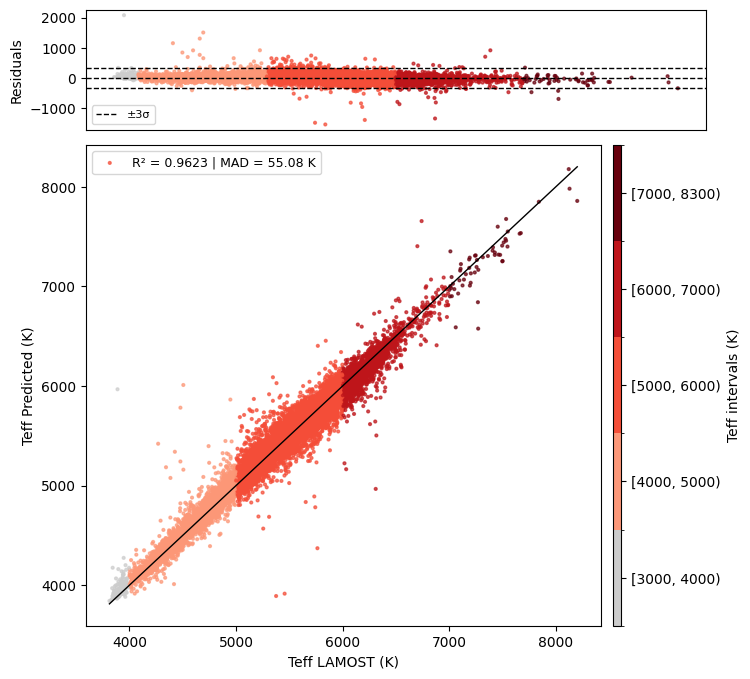


Gerando gráfico para logg...


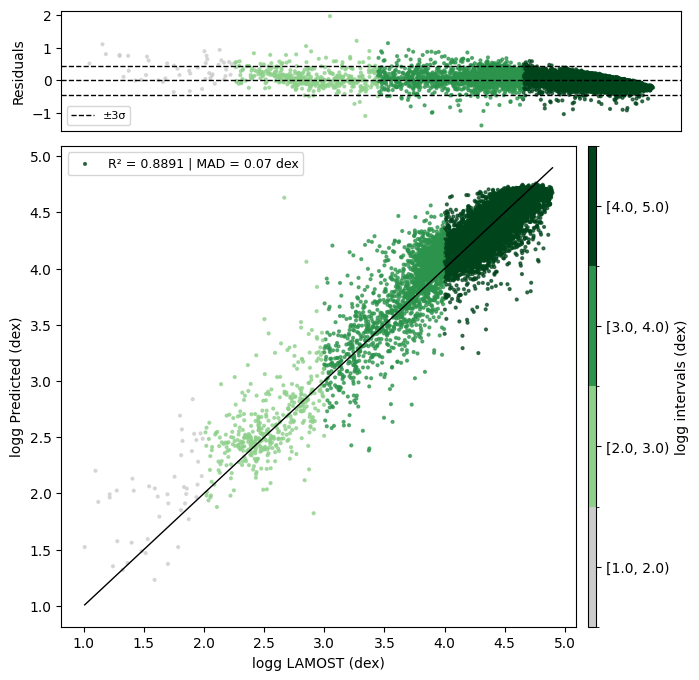


Gerando gráfico para feh...


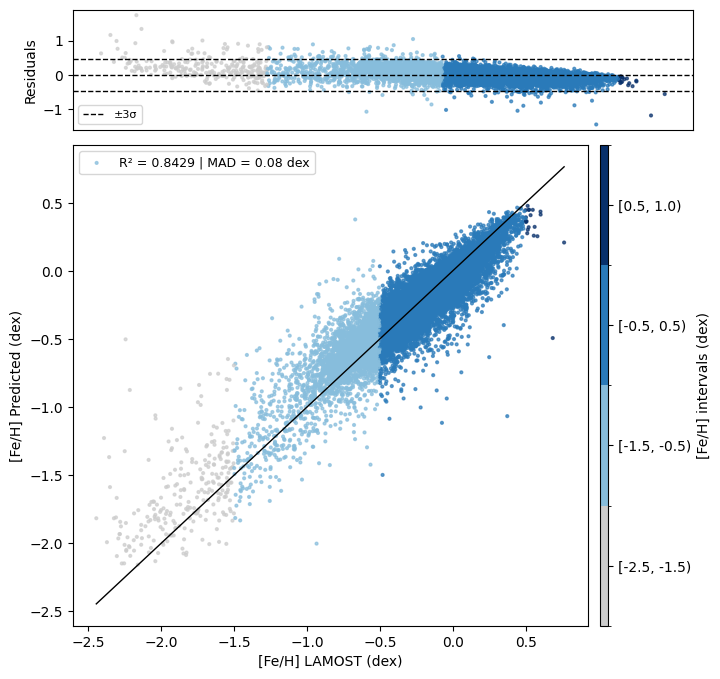


=== GRÁFICOS CONCLUÍDOS ===


In [10]:
import importlib
import minas.evaluation._graphics
importlib.reload(minas.evaluation._graphics)  

training_id = 20251014174921  # Use o ID da execução atual ou substitua por um ID específico

print(f"=== GERANDO GRÁFICOS PARA TRAINING ID: {training_id} ===")


metrics_table = []
for param in ['teff', 'logg', 'feh']:
    results_path = f'predicts/{training_id}_{survey_train}_{param}{model_rest}_{model_type}.csv'
    metrics_path = results_path.replace('.csv', '_metrics.json')
    
    if not os.path.exists(results_path) or not os.path.exists(metrics_path):
        continue
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)
    metrics_table.append({
        'Parâmetro': param,
        'R²': metrics['r2'],
        'MAD': metrics['mad']
    })

if metrics_table:
    df_metrics = pd.DataFrame(metrics_table)
    print("\nMétricas por parâmetro:")
    print(df_metrics.to_string(index=False, float_format='%.4f'))
else:
    print("Nenhuma métrica encontrada para os parâmetros.")

# Gerar gráficos
survey_code = survey_train[-1] if len(survey_train) > len('SPLUS') else ''
for param in ['teff', 'logg', 'feh']:
    try:
        results_path = f'predicts/{training_id}_{survey_train}_{param}{model_rest}_{model_type}.csv'
        metrics_path = results_path.replace('.csv', '_metrics.json')
        
        if not os.path.exists(results_path) or not os.path.exists(metrics_path):
            continue
        results_df = pd.read_csv(results_path, index_col=0)
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
        
        param_config = next((c for c in param_configs if c['param'] == param), None)
        if param_config is None:
            continue
        bins = param_config['bins']
        param_col = [col for col in results_df.columns if col not in ['Predicted', 'Residuos', 'RA', 'DEC']][0]
        print(f"\nGerando gráfico para {param}...")
        fig = mg.evaluation._graphics.plot_regression_with_residuals(
            y_true=results_df[param_col],
            y_pred=results_df['Predicted'],
            bins=bins,
            param_name=param,
            point_size=4,
            metrics_json_path=metrics_path,
            training_id=training_id,
            survey_name=survey_code
        )
        graphs_results = 'graphs_results'
        os.makedirs(graphs_results, exist_ok=True)
        fig.savefig(f"{graphs_results}/{training_id}_{survey_train}_{param}{model_rest}_{model_type}.png", bbox_inches='tight')
        mg.evaluation._graphics.show(fig)
    except Exception as e:
        print(f"Erro ao gerar gráfico para {param}: {e}")

print("\n=== GRÁFICOS CONCLUÍDOS ===")